# Glaucoma detection with Vision-Transformers

Done by: Sebastian Sarasti

## Import libraries

In [ ]:
pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 6.9 MB/s eta 0:00:00


In [ ]:
import transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%%capture
!pip install datasets

# Download data from kaggle

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sabari50312/fundus-pytorch

 99% 3.79G/3.82G [00:49<00:00, 96.5MB/s]
100% 3.82G/3.82G [00:49<00:00, 82.9MB/s]


In [ ]:
%%capture
!unzip /content/fundus-pytorch.zip

# Load data

Se the device

In [ ]:
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Create a transformation and function to read images from the folder

In [ ]:
from torchvision import transforms, datasets

Import a image processor for the ViT

In [ ]:
from transformers import AutoImageProcessor

In [ ]:
repo_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = AutoImageProcessor.from_pretrained(repo_id)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Load data from the disk

In [ ]:
transformations = transforms.Compose([
    feature_extractor,
])

In [ ]:
dataset_train = datasets.ImageFolder(root='/content/train', transform=transformations)

In [ ]:
dataset_val = datasets.ImageFolder(root='/content/val', transform=transformations)

In [ ]:
dataset_test = datasets.ImageFolder(root='/content/test', transform=transformations)

In [ ]:
type(dataset_train[0][0]['pixel_values'][0])

numpy.ndarray

In [ ]:
dataset_train[0][1]

0

Create a collector function

In [ ]:
def collector_function(batch):
    inputs = torch.tensor(np.stack([sample[0]['pixel_values'][0] for sample in batch]), dtype=torch.float32).to(device)
    labels = torch.tensor([sample[1] for sample in batch], dtype=torch.float32).view(-1, 1).to(device)
    return inputs, labels

Create a dataloader

In [ ]:
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn = collector_function)

In [ ]:
data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=32, shuffle=True, collate_fn = collector_function)

In [ ]:
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True, collate_fn = collector_function)

# Create the model

In [ ]:
from transformers import AutoImageProcessor, ViTModel
import torch
from tqdm import tqdm

based_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
import torch.nn as nn

In [ ]:
class EyeDiseaseClassifier(nn.Module):
  def __init__(self, based_model):
    super(EyeDiseaseClassifier, self).__init__()
    self.base_model = based_model
    self.flatten_layer = nn.Flatten()
    self.linear_layer1 = nn.Linear(768*197, 200)
    self.act1 = nn.ReLU()
    self.linear_layer2 = nn.Linear(200, 1)
    self.act2 = nn.Sigmoid()

    # freeze the layers in the base_model to avoid the retraining and apply transfer learning
    for param in self.base_model.parameters():
        param.requires_grad = False

  def forward(self, inputs):
    x = self.base_model(inputs)
    x = x['last_hidden_state']
    x = self.flatten_layer(x)
    x = self.linear_layer1(x)
    x = self.act1(x)
    x = self.linear_layer2(x)
    x = self.act2(x)
    return x

In [ ]:
model = EyeDiseaseClassifier(based_model).to(device)

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Create a function to evaluate the model

In [ ]:
def validate(model, data_loader, criterion):
    model.eval()  # Poner el modelo en modo de evaluación
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in data_loader:
            predictions = model(inputs)
            loss = criterion(predictions, labels)

            predicted = (predictions > 0.5).float()
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            total_loss += loss.item()

    accuracy = total_correct / total_samples
    average_loss = total_loss / len(data_loader)

    return average_loss, accuracy

In [ ]:
epochs = 10
loss_train = []
acc_train = []
loss_val = []
acc_val = []
initial_val_loss = float('inf')
for epoch in tqdm(range(epochs)):
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    # Wrap your DataLoader with tqdm
    for inputs, labels in data_loader_train:
        # Forward pass
        predictions = model(inputs)
        loss = criterion(predictions, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        # Assuming your model outputs probabilities (e.g., using Sigmoid activation)
        predicted = (predictions > 0.5).float()
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Accumulate total loss
        total_loss += loss.item()

    # Calculate accuracy and average loss for the epoch
    accuracy = total_correct / total_samples
    average_loss = total_loss / len(data_loader_train)

    # Append and save the values of accuracy and loss in the training
    loss_train.append(average_loss)
    acc_train.append(accuracy)

    # Evaluate the model and also save the accuracy and loss
    loss_val_r, ac_val_r  = validate(model = model, data_loader = data_loader_val, criterion = criterion)

    if loss_val_r < initial_val_loss:
      torch.save(model.state_dict(), 'mejor_modelo.pt')

    initial_val_loss = loss_val_r

    loss_val.append(loss_val_r)
    acc_val.append(ac_val_r)

    print(f'Epoch {epoch+1}/{epochs}, Loss training: {average_loss:.4f}, Accuracy training: {accuracy:.4f}, Loss validation: {loss_val_r:.4f}, Accuracy validation: {ac_val_r:.4f}')

 10%|█         | 1/10 [07:20<1:06:05, 440.56s/it]

Epoch 1/10, Loss training: 1.2831, Accuracy training: 0.7636, Loss validation: 0.3400, Accuracy validation: 0.8526


 20%|██        | 2/10 [14:23<57:23, 430.42s/it]  

Epoch 2/10, Loss training: 0.3520, Accuracy training: 0.8482, Loss validation: 0.2783, Accuracy validation: 0.8864


 30%|███       | 3/10 [21:30<49:59, 428.55s/it]

Epoch 3/10, Loss training: 0.3098, Accuracy training: 0.8675, Loss validation: 0.2364, Accuracy validation: 0.9033


 40%|████      | 4/10 [28:26<42:22, 423.81s/it]

Epoch 4/10, Loss training: 0.2858, Accuracy training: 0.8757, Loss validation: 0.2998, Accuracy validation: 0.8707


 50%|█████     | 5/10 [35:26<35:11, 422.37s/it]

Epoch 5/10, Loss training: 0.2631, Accuracy training: 0.8892, Loss validation: 0.1842, Accuracy validation: 0.9280


 60%|██████    | 6/10 [42:19<27:56, 419.17s/it]

Epoch 6/10, Loss training: 0.2375, Accuracy training: 0.9022, Loss validation: 0.1957, Accuracy validation: 0.9273


 70%|███████   | 7/10 [49:09<20:48, 416.06s/it]

Epoch 7/10, Loss training: 0.2032, Accuracy training: 0.9139, Loss validation: 0.6463, Accuracy validation: 0.7642


 80%|████████  | 8/10 [56:05<13:52, 416.20s/it]

Epoch 8/10, Loss training: 0.2093, Accuracy training: 0.9132, Loss validation: 0.5081, Accuracy validation: 0.7461


 90%|█████████ | 9/10 [1:03:03<06:56, 416.81s/it]

Epoch 9/10, Loss training: 0.1731, Accuracy training: 0.9277, Loss validation: 0.1110, Accuracy validation: 0.9596


100%|██████████| 10/10 [1:10:42<00:00, 424.23s/it]

Epoch 10/10, Loss training: 0.1472, Accuracy training: 0.9419, Loss validation: 0.0948, Accuracy validation: 0.9685


Plot how the model was trained

Text(0, 0.5, 'Loss value')

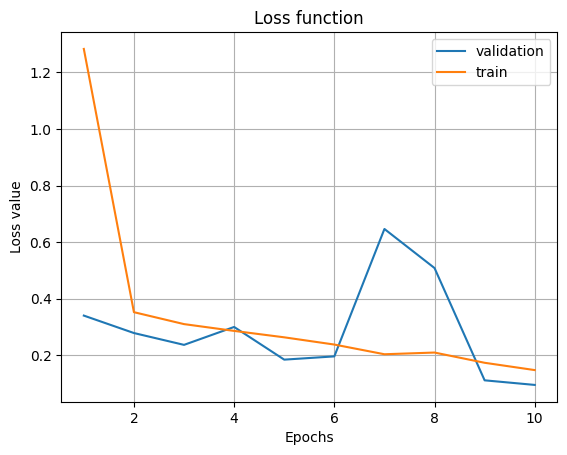

In [ ]:
plt.plot(range(1, len(loss_val)+1), loss_val, label = 'validation')
plt.plot(range(1, len(loss_train)+1), loss_train, label = 'train')
plt.grid()
plt.title('Loss function')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')

Text(0, 0.5, 'Loss value')

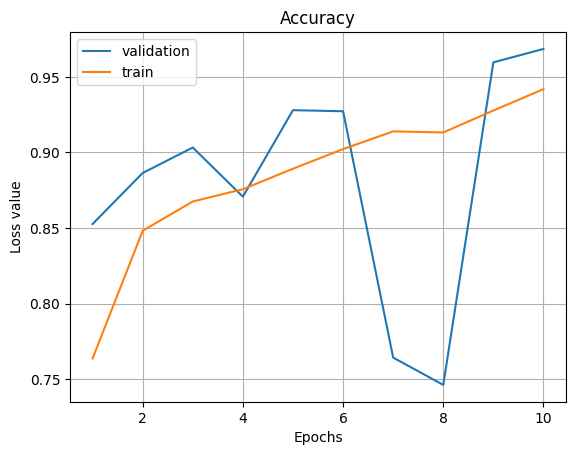

In [ ]:
plt.plot(range(1, len(acc_val) + 1), acc_val, label = 'validation')
plt.plot(range(1, len(acc_train) + 1), acc_train, label = 'train')
plt.grid()
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')

Generate a checkpoint to save the model

In [ ]:
checkpoint = {
    "model_state_dict" :  model.state_dict(),
    "optimizer_state_dict" : optimizer.state_dict(),
    "epoch" : epoch,
    "validation loss" : loss_val[-1],
    "validation accuracy" : acc_val[-1]
}

torch.save(checkpoint, "model_checkpoint.pth")

Once the best model has been gotten, it is going to be pushed the model to the hugging face portal.

In [ ]:
%%capture
!pip install huggingface_hub

In [ ]:
from google.colab import userdata

In [ ]:
token = userdata.get('hugging_face_token')

In [ ]:
import os

In [ ]:
os.environ['HUGGINGFACE_TOKEN'] = token

In [ ]:
!huggingface-cli login --token $HUGGINGFACE_TOKEN

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from huggingface_hub import HfApi

In [ ]:
api = HfApi()

In [ ]:
api.create_repo(repo_id="sebastiansarasti/glaucoma-clasification")

RepoUrl('https://huggingface.co/sebastiansarasti/glaucoma-clasification', endpoint='https://huggingface.co', repo_type='model', repo_id='sebastiansarasti/glaucoma-clasification')

In [ ]:
api.upload_file(
    path_or_fileobj="./model_checkpoint.pth",
    path_in_repo="model_checkpoint.pth",
    repo_id="sebastiansarasti/glaucoma-clasification"
)

model_checkpoint.pth:   0%|          | 0.00/709M [00:00<?, ?B/s]

'https://huggingface.co/sebastiansarasti/glaucoma-clasification/blob/main/model_checkpoint.pth'

Make the predictions

In [ ]:
model.eval()
real_labels = []
predicted_labels = []

for inputs, labels in data_loader_test:
    with torch.no_grad():
        outputs = model(inputs)
        predictions = (outputs > 0.5).int()
        real_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

See the performance of the classification

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(real_labels, predicted_labels))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      1754
         1.0       0.97      0.94      0.95      1120

    accuracy                           0.97      2874
   macro avg       0.97      0.96      0.96      2874
weighted avg       0.97      0.97      0.97      2874

